# Restricted Boltzmann Machine - MNIST

## Imports

In [ ]:
import sys, datetime

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG
!mkdir FIG/FRAME
!mkdir WEIGHTS
!mkdir DATA

## Load data

In [ ]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

(70000, 784)


## Parameters

In [ ]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 5
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################


# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L

if POTTS and SPINS:
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


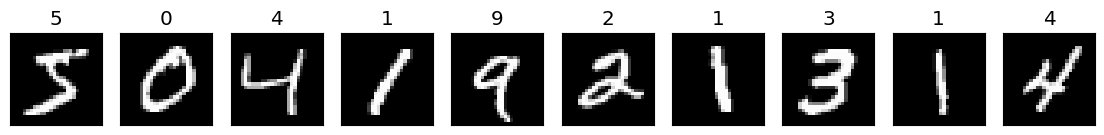

first 10 MNIST-3 data points


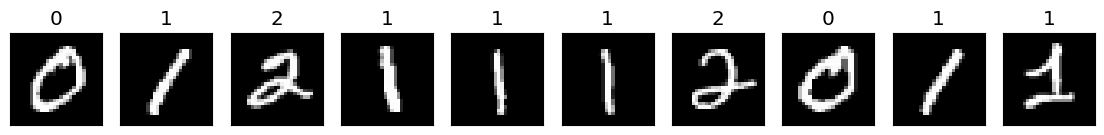

first 10 MNIST-3 data points, binarized


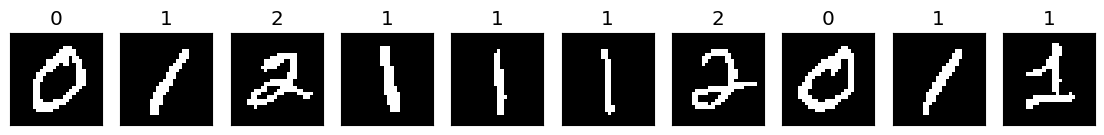

each of Nd=21770 data has D=784 bits


In [ ]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))

    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "gray"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()

def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

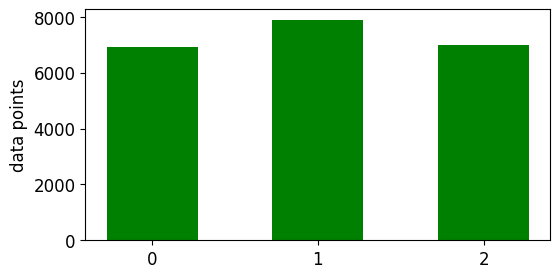

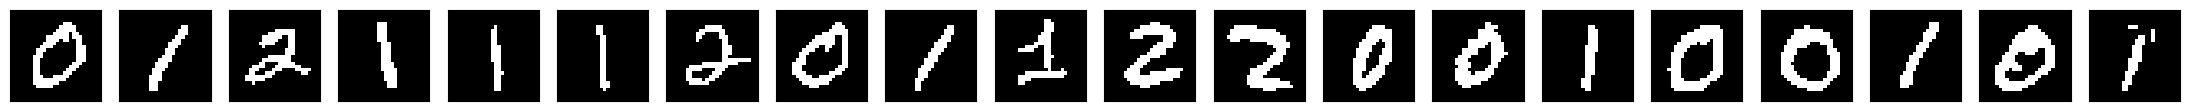

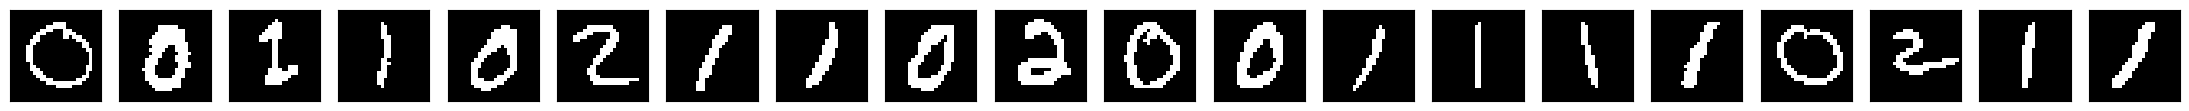

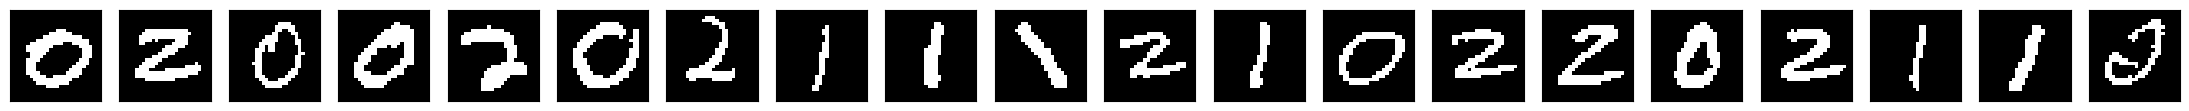

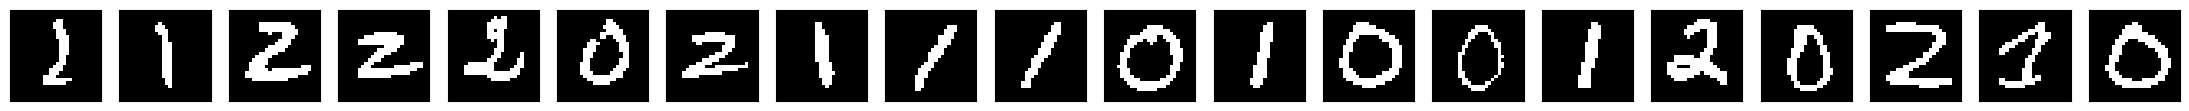

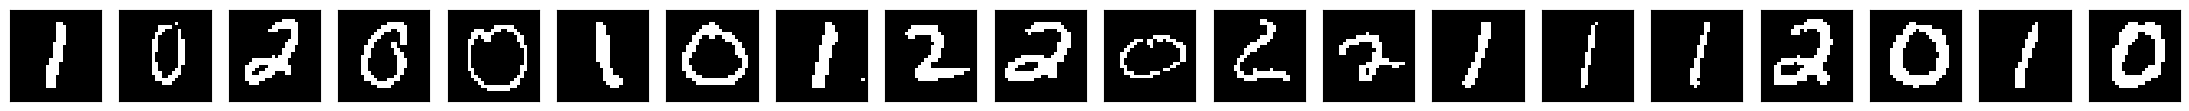

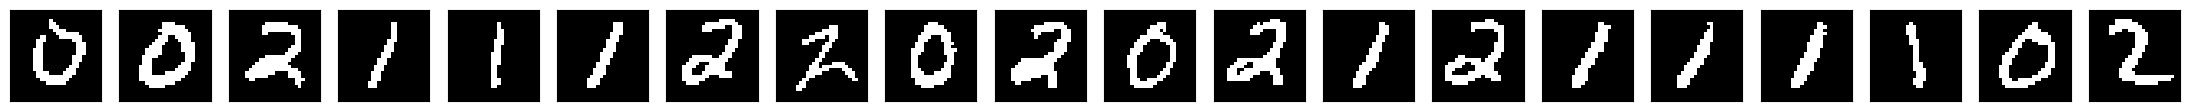

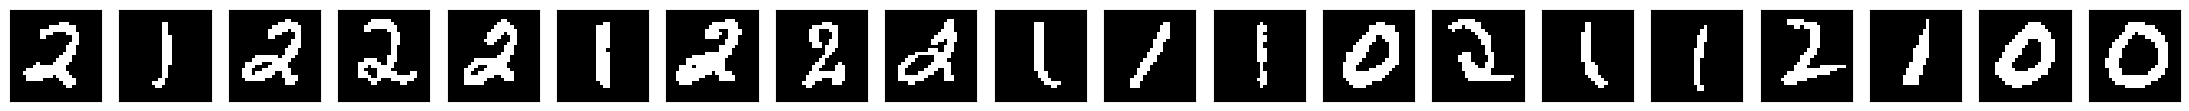

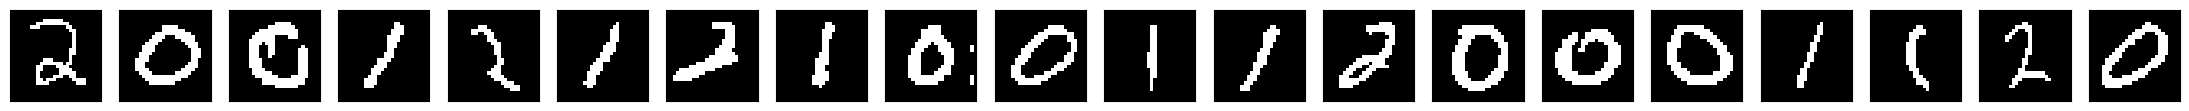

In [ ]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [ ]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer:
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a)

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [ ]:
# def plot_weights_bias(wE, bE, epoch, L,
#                       side=0,cols=0,thr=0,s=1.5,
#                       title=False, save=True,cmap="bwr"):
#     '''
#     Plot the weights of the RBM, one plot for each hidden unit.
#     '''
#     rows = int(np.ceil(L / cols))
#     if rows==1: rows=2
#     w=wE[epoch]
#     b=bE[epoch]
#     if side==0: side=int(sqrt(len(w)))
#     if thr==0: thr=4
#     plt.clf()
#     fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
#     if title: fig.suptitle(f"epoch = {epoch}")
#     k=1
#     for i in range(rows):
#         for j in range(cols):
#             if rows==1: ax=AX[j+1]
#             else: ax=AX[i,j+1]
#             if k<=L:
#                 ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 ax.set_title(f"hidden {k}")
#             else: fig.delaxes(ax)
#             k+=1
#         if i>0:  fig.delaxes(AX[i,0])

#     ax=AX[0,0];
#     im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title("bias")
#     # colobar
#     cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
#     cbar = fig.colorbar(im, cax=cbar_ax)
#     cbar.ax.tick_params(labelsize=12)

#     S=0.3
#     plt.subplots_adjust(hspace=S)

#     if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

#     plt.show()
#     plt.close()
def plot_weights_bias(wE, aE, epoch, L, title="Weights and Biases"):
    fig, axes = plt.subplots(1, L + 1, figsize=(L * 1.5, 2))

    for i in range(L):
        axes[i].imshow(wE[epoch, :, i].reshape((int(np.sqrt(wE.shape[1])), -1)), cmap='bwr', vmin=-1, vmax=1)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Hid {i}")

    axes[-1].imshow(aE[epoch].reshape((int(np.sqrt(aE.shape[1])), -1)), cmap='bwr', vmin=-1, vmax=1)
    axes[-1].set_xticks([])
    axes[-1].set_yticks([])
    axes[-1].set_title("Bias")

    plt.suptitle(title)
    plt.show()

## Weights initialization

In [ ]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)

# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [ ]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[0]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

D=784	sample size
L=5	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
gamma=0.001	regularization


# RBM train


In [ ]:
def train_rbm(data, L, l_rate_ini, sigma, Nepoch=150 , Nmini=20 , N_ini=10 , N_fin=500, Nt=2):
  np.random.seed(12345)
  w = sigma * np.random.randn(D,L)
  a = Hinton_bias_init(data)
  b = np.zeros(L)
  Nepoch=100
  Nmini=20
  N_ini,N_fin=10,500
  print(f"Nepoch={Nepoch}\nNmini={Nmini}")
  Nt=2
  wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
  wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
  gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
  gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
  gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
  miniE = np.zeros(Nepoch+1)
  pzE=np.zeros((Nepoch+1,Nz))
  if GRAD=="RMSprop":
      gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
  indices=np.arange(Nd).astype("int")
  plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
  Ncols=min(8,max(2,L//2))


  if POTTS: print("Starting the training, POTTS=True")
  else: print("Starting the training")
  for epoch in range(1,1+Nepoch):
      q = (epoch-1.)/(Nepoch-1.)
      N = int(N_ini + (N_fin-N_ini)*(q**2))
      l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

      for mini in range(Nmini):
          x_data, x_model = np.zeros(D),np.zeros(D)
          z_data, z_model = np.zeros(L),np.zeros(L)
          xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
          pz = np.zeros(L)
          selected = np.random.choice(indices,N,replace=False)
          if epoch==1 and mini<=3: print(selected)

          for k in range(N):
              x0 = data[selected[k]]
              z = CD_step(x0,w,b,POTTS=POTTS)
              x_data  += x0
              z_data  += z
              xz_data += np.outer(x0,z)
              zf=np.copy(z)
              for t in range(Nt):
                  xf = CD_step(zf,w.T,a)
                  zf = CD_step(xf,w,b,POTTS=POTTS)
              x_model += xf
              z_model += zf
              xz_model+= np.outer(xf,zf)
              if POTTS: pz[zf]+=1
          gw_d,gw_m = xz_data/N, xz_model/N
          ga_d,ga_m = x_data/N, x_model/N
          gb_d,gb_m = z_data/N, z_model/N
          gw=np.copy(gw_d - gw_m)
          ga=np.copy(ga_d - ga_m)
          gb=np.copy(gb_d - gb_m)

          if GRAD=="RMSprop":
              gw2 = beta*gw2+(1-beta)*np.square(gw)
              ga2 = beta*ga2+(1-beta)*np.square(ga)
              gb2 = beta*gb2+(1-beta)*np.square(gb)
              w += l_rate*gw/sqrt(epsilon+gw2)
              a += l_rate*ga/sqrt(epsilon+ga2)
              b += l_rate*gb/sqrt(epsilon+gb2)
          else:
              w += l_rate*gw
              a += l_rate*ga
              b += l_rate*gb
          if gamma>0.:
              w -= (gamma*l_rate)*sign(w)
              a -= (gamma*l_rate)*sign(a)
              b -= (gamma*l_rate)*sign(b)

      wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
      aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
      bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
      miniE[epoch]=N
      if POTTS: pzE[epoch] = pz/np.sum(pz)
      print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
            " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)

      if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
          plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)

      str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")

  print("END of learning phase")
  return {"wE": wE, "aE": aE, "bE": bE, "x0": x0}

In [ ]:
import numpy as np

def sample_h_given_v(v, w, b):
    """Computes hidden unit activations and samples binary states."""
    prob_h = sigmoid(np.dot(v, w) + b)
    return prob_h, (prob_h > np.random.rand(*prob_h.shape)).astype(np.float32)

def sample_v_given_h(h, w, a):
    """Computes visible unit activations and samples binary states."""
    prob_v = sigmoid(np.dot(h, w.T) + a)
    return prob_v, (prob_v > np.random.rand(*prob_v.shape)).astype(np.float32)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def CD_step(v, w, b, a, k=1):
    """Performs k-step Contrastive Divergence (CD-k)."""
    for _ in range(k):
        _, h = sample_h_given_v(v, w, b)
        _, v = sample_v_given_h(h, w, a)
    return v

def train_rbm_cd(data, L, l_rate, sigma, Nepoch=100, Nmini=20):
    """Trains an RBM using Contrastive Divergence (CD-1)."""
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.zeros(D)
    b = np.zeros(L)

    for epoch in range(Nepoch):
        for mini in range(Nmini):
            batch = data[np.random.choice(data.shape[0], size=10, replace=False)]
            pos_h_probs, pos_h_states = sample_h_given_v(batch, w, b)
            neg_v_probs = CD_step(batch, w, b, a, k=1)
            neg_h_probs, _ = sample_h_given_v(neg_v_probs, w, b)

            w += l_rate * (np.dot(batch.T, pos_h_probs) - np.dot(neg_v_probs.T, neg_h_probs)) / len(batch)
            a += l_rate * np.mean(batch - neg_v_probs, axis=0)
            b += l_rate * np.mean(pos_h_probs - neg_h_probs, axis=0)

    return {"w": w, "a": a, "b": b}

def train_rbm_pcd(data, L, l_rate, sigma, Nepoch=100, Nmini=20):
    """Trains an RBM using Persistent Contrastive Divergence (pCD-1)."""
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.zeros(D)
    b = np.zeros(L)
    persistent_v = data[np.random.choice(data.shape[0], size=10, replace=False)]  # Initialize chain

    for epoch in range(Nepoch):
        for mini in range(Nmini):
            batch = data[np.random.choice(data.shape[0], size=10, replace=False)]
            pos_h_probs, pos_h_states = sample_h_given_v(batch, w, b)

            # Use persistent chain for model samples
            persistent_v = CD_step(persistent_v, w, b, a, k=1)
            neg_h_probs, _ = sample_h_given_v(persistent_v, w, b)

            w += l_rate * (np.dot(batch.T, pos_h_probs) - np.dot(persistent_v.T, neg_h_probs)) / len(batch)
            a += l_rate * np.mean(batch - persistent_v, axis=0)
            b += l_rate * np.mean(pos_h_probs - neg_h_probs, axis=0)

    return {"w": w, "a": a, "b": b}

def train_rbm_pt(data, L, l_rate, sigma, Nepoch=100, Nmini=20, Nreplicas=10):
    """Trains an RBM using Parallel Tempering (PT)."""
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.zeros(D)
    b = np.zeros(L)

    # Initialize parallel chains at different temperatures
    temperatures = np.logspace(0, 2, Nreplicas)
    replicas = [data[np.random.choice(data.shape[0], size=10, replace=False)] for _ in range(Nreplicas)]

    for epoch in range(Nepoch):
        for mini in range(Nmini):
            batch = data[np.random.choice(data.shape[0], size=10, replace=False)]
            pos_h_probs, pos_h_states = sample_h_given_v(batch, w, b)

            # Sample from all replicas
            for i in range(Nreplicas):
                replicas[i] = CD_step(replicas[i], w, b, a, k=1)

            # Perform Metropolis-Hastings exchange moves
            for i in range(Nreplicas - 1):
                energy_diff = np.mean(replicas[i]) - np.mean(replicas[i+1])
                if np.random.rand() < np.exp(-energy_diff * (1/temperatures[i] - 1/temperatures[i+1])):
                    replicas[i], replicas[i+1] = replicas[i+1], replicas[i]  # Swap states

            neg_v_probs = replicas[0]  # Use the lowest-temperature replica
            neg_h_probs, _ = sample_h_given_v(neg_v_probs, w, b)

            w += l_rate * (np.dot(batch.T, pos_h_probs) - np.dot(neg_v_probs.T, neg_h_probs)) / len(batch)
            a += l_rate * np.mean(batch - neg_v_probs, axis=0)
            b += l_rate * np.mean(pos_h_probs - neg_h_probs, axis=0)
    return {"w": w, "a": a, "b": b}
w_pt,a_pt,b_pt=train_rbm_pt(data,L=5,l_rate=0.1,sigma=0.01,Nepoch=100,Nmini=20,Nreplicas=10)["w"],train_rbm_pt(data,L=5,l_rate=0.1,sigma=0.01,Nepoch=100,Nmini=20,Nreplicas=10)["a"],train_rbm_pt(data,L=5,l_rate=0.1,sigma=0.01,Nepoch=100,Nmini=20,Nreplicas=10)["b"]

In [ ]:
def train_rbm_compare_algorithms(data, L, l_rate_ini, sigma, Nepoch=100, Nmini=20, N_ini=10, N_fin=500, Nt=2):
    np.random.seed(12345)
    results = {}
    algorithms = ['CD', 'PCD', 'PT']

    for algo in algorithms:
        print(f"\n--- Training with {algo} ---")
        w = sigma * np.random.randn(D, L)
        a = Hinton_bias_init(data)
        b = np.zeros(L)
        wE, aE, bE = np.zeros((Nepoch+1, D, L)), np.zeros((Nepoch+1, D)), np.zeros((Nepoch+1, L))
        wE[0], aE[0], bE[0] = np.copy(w), np.copy(a), np.copy(b)

        if algo == 'PCD':
            persistent_z = np.random.randint(0, 2, size=(Nd, L))

        if algo == 'PT':
            n_chains = 5
            betas = np.linspace(0.1, 1.0, n_chains)
            pt_states = [np.random.randint(0, 2, size=(Nd, L)) for _ in range(n_chains)]

        for epoch in range(1, Nepoch+1):
            q = (epoch - 1) / (Nepoch - 1)
            N = int(N_ini + (N_fin - N_ini) * (q ** 2))
            l_rate = l_rate_ini + (l_rate_fin - l_rate_ini) * q

            for mini in range(Nmini):
                x_data, x_model = np.zeros(D), np.zeros(D)
                z_data, z_model = np.zeros(L), np.zeros(L)
                xz_data, xz_model = np.zeros((D, L)), np.zeros((D, L))

                selected = np.random.choice(Nd, N, replace=False)

                for k in range(N):
                    x0 = data[selected[k]]
                    z = CD_step(x0, w, b, POTTS=POTTS)
                    x_data += x0
                    z_data += z
                    xz_data += np.outer(x0, z)

                    if algo == 'CD':
                        zf = np.copy(z)
                        for t in range(Nt):
                            xf = CD_step(zf, w.T, a)
                            zf = CD_step(xf, w, b, POTTS=POTTS)

                    elif algo == 'PCD':
                        for t in range(Nt):
                            persistent_x = CD_step(persistent_z[selected[k]], w.T, a)
                            persistent_z[selected[k]] = CD_step(persistent_x, w, b, POTTS=POTTS)
                        xf = persistent_x
                        zf = persistent_z[selected[k]]

                    elif algo == 'PT':
                        chains = pt_states
                        for t in range(Nt):
                            for i in range(len(chains)):
                                vi = CD_step(chains[i][selected[k]], w.T, a)
                                chains[i][selected[k]] = CD_step(vi, w, b, POTTS=POTTS)
                            # Swap step
                            for i in range(len(chains) - 1):
                                E1 = -np.dot(chains[i][selected[k]], b)
                                E2 = -np.dot(chains[i+1][selected[k]], b)
                                swap_prob = np.exp((betas[i] - betas[i+1]) * (E2 - E1))
                                if np.random.rand() < swap_prob:
                                    chains[i][selected[k]], chains[i+1][selected[k]] = chains[i+1][selected[k]], chains[i][selected[k]]
                        pt_states = chains
                        zf = pt_states[-1][selected[k]]
                        xf = CD_step(zf, w.T, a)

                    x_model += xf
                    z_model += zf
                    xz_model += np.outer(xf, zf)

                gw = (xz_data - xz_model) / N
                ga = (x_data - x_model) / N
                gb = (z_data - z_model) / N

                if GRAD == "RMSprop":
                    gw2 = beta * gw2 + (1 - beta) * np.square(gw)
                    ga2 = beta * ga2 + (1 - beta) * np.square(ga)
                    gb2 = beta * gb2 + (1 - beta) * np.square(gb)
                    w += l_rate * gw / np.sqrt(epsilon + gw2)
                    a += l_rate * ga / np.sqrt(epsilon + ga2)
                    b += l_rate * gb / np.sqrt(epsilon + gb2)
                else:
                    w += l_rate * gw
                    a += l_rate * ga
                    b += l_rate * gb

                if gamma > 0.:
                    w -= (gamma * l_rate) * np.sign(w)
                    a -= (gamma * l_rate) * np.sign(a)
                    b -= (gamma * l_rate) * np.sign(b)

            wE[epoch], aE[epoch], bE[epoch] = np.copy(w), np.copy(a), np.copy(b)
            if Nepoch <= 100 or epoch % 20 == 0 or epoch == Nepoch:
                plot_weights_bias(wE, aE, epoch, L)

        results[algo] = {"wE": wE, "aE": aE, "bE": bE}
    return results


In [ ]:
train_rbm_compare_algorithms(data, L, l_rate_ini, sigma, Nepoch=100, Nmini=20, N_ini=10, N_fin=500, Nt=2)

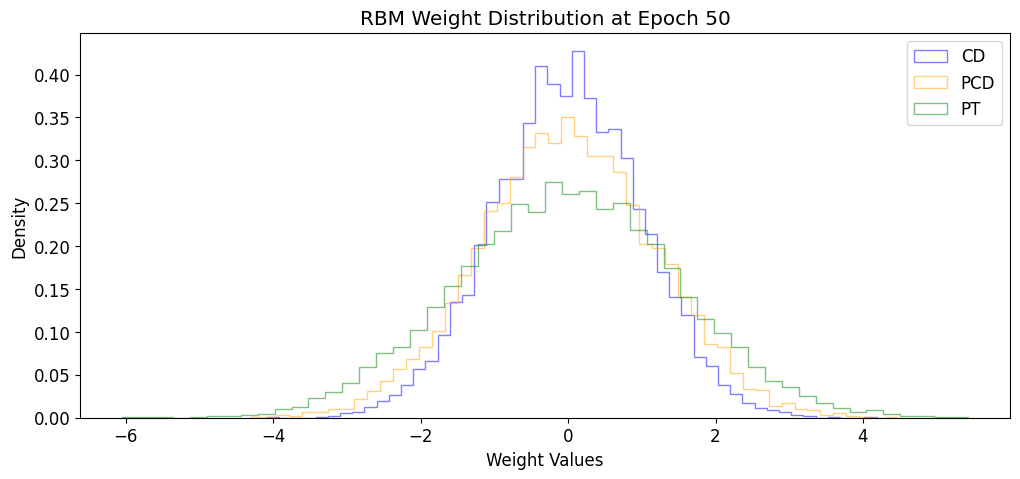

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_weight_histogram(weights_cd, weights_pcd, weights_pt, epoch):
    plt.figure(figsize=(12, 5))
    plt.hist(weights_cd.flatten(), bins=50, alpha=0.5, label='CD', color='blue', histtype="step", density=True)
    plt.hist(weights_pcd.flatten(), bins=50, alpha=0.5, label='PCD', color='orange', histtype="step", density=True)
    plt.hist(weights_pt.flatten(), bins=50, alpha=0.5, label='PT', color='green', histtype="step", density=True)
    plt.xlabel("Weight Values")
    plt.ylabel("Density")
    plt.title(f"RBM Weight Distribution at Epoch {epoch}")
    plt.legend()
    plt.show()

# Example Usage (replace with actual computed weights from RBM training)
weights_cd = np.random.randn(100, 100)
weights_pcd = np.random.randn(100, 100) * 1.2
weights_pt = np.random.randn(100, 100) * 1.5
plot_weight_histogram(weights_cd, weights_pcd, weights_pt, epoch=50)


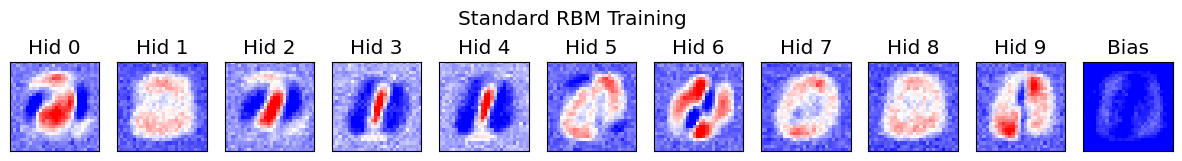

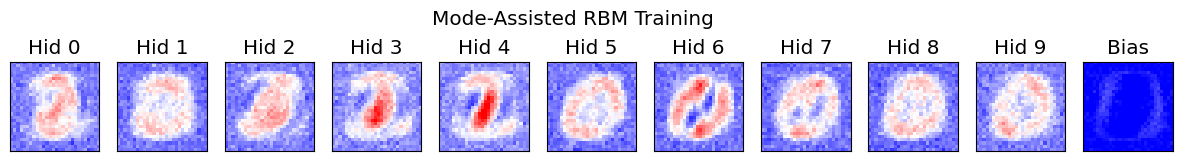

In [ ]:
def train_rbm_with_mode_assistance(data, L, l_rate_ini, sigma, Nepoch=150, Nmini=20, N_ini=10, N_fin=500, Nt=2, mode_assisted=False):
    np.random.seed(12345)
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.mean(data, axis=0)
    b = np.zeros(L)

    wE, aE, bE = np.zeros((Nepoch + 1, D, L)), np.zeros((Nepoch + 1, D)), np.zeros((Nepoch + 1, L))
    wE[0], aE[0], bE[0] = np.copy(w), np.copy(a), np.copy(b)

    for epoch in range(1, Nepoch + 1):
        N = int(N_ini + (N_fin - N_ini) * ((epoch - 1) / (Nepoch - 1)) ** 2)
        l_rate = l_rate_ini

        for mini in range(Nmini):
            batch_indices = np.random.choice(len(data), N, replace=False)
            batch_data = data[batch_indices]

            pos_hidden_probs = 1 / (1 + np.exp(-batch_data @ w - b))
            pos_hidden_states = (pos_hidden_probs > np.random.rand(*pos_hidden_probs.shape)).astype(int)

            neg_visible_probs = 1 / (1 + np.exp(-pos_hidden_states @ w.T - a))
            neg_hidden_probs = 1 / (1 + np.exp(-neg_visible_probs @ w - b))

            if mode_assisted:
                most_common_state = np.round(np.mean(pos_hidden_states, axis=0))
                pos_hidden_states = (pos_hidden_states + most_common_state) / 2

            dw = (batch_data.T @ pos_hidden_states - neg_visible_probs.T @ neg_hidden_probs) / N
            da = np.mean(batch_data - neg_visible_probs, axis=0)
            db = np.mean(pos_hidden_states - neg_hidden_probs, axis=0)

            w += l_rate * dw
            a += l_rate * da
            b += l_rate * db

        wE[epoch], aE[epoch], bE[epoch] = np.copy(w), np.copy(a), np.copy(b)

    return wE, aE, bE
def plot_weights_bias(wE, aE, epoch, L, title="Weights and Biases"):
    fig, axes = plt.subplots(1, L + 1, figsize=(L * 1.5, 2))

    for i in range(L):
        axes[i].imshow(wE[epoch, :, i].reshape((int(np.sqrt(wE.shape[1])), -1)), cmap='bwr', vmin=-1, vmax=1)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Hid {i}")

    axes[-1].imshow(aE[epoch].reshape((int(np.sqrt(aE.shape[1])), -1)), cmap='bwr', vmin=-1, vmax=1)
    axes[-1].set_xticks([])
    axes[-1].set_yticks([])
    axes[-1].set_title("Bias")

    plt.suptitle(title)
    plt.show()
L = 10
sigma = 0.1
l_rate_ini = 0.01

wE_std, aE_std, bE_std = train_rbm_with_mode_assistance(data, L, l_rate_ini, sigma, mode_assisted=False)
wE_mat, aE_mat, bE_mat = train_rbm_with_mode_assistance(data, L, l_rate_ini, sigma, mode_assisted=True)

plot_weights_bias(wE_std, aE_std, -1, L, "Standard RBM Training")
plot_weights_bias(wE_mat, aE_mat, -1, L, "Mode-Assisted RBM Training")


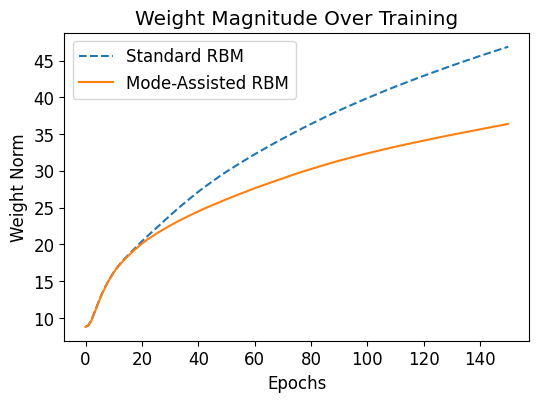

In [ ]:
def plot_weight_magnitude(wE_std, wE_mat):
    epochs = wE_std.shape[0]
    weight_norm_std = np.linalg.norm(wE_std.reshape(epochs, -1), axis=1)
    weight_norm_mat = np.linalg.norm(wE_mat.reshape(epochs, -1), axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(weight_norm_std, label="Standard RBM", linestyle="dashed")
    plt.plot(weight_norm_mat, label="Mode-Assisted RBM", linestyle="solid")
    plt.xlabel("Epochs")
    plt.ylabel("Weight Norm")
    plt.title("Weight Magnitude Over Training")
    plt.legend()
    plt.show()

plot_weight_magnitude(wE_std, wE_mat)


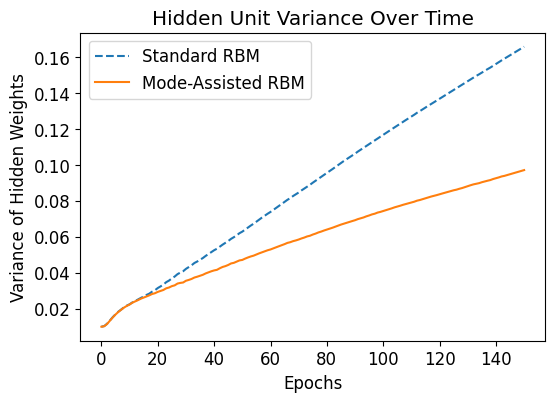

In [ ]:
def plot_hidden_unit_variance(wE_std, wE_mat):
    epochs = wE_std.shape[0]
    var_std = np.var(wE_std, axis=(1, 2))
    var_mat = np.var(wE_mat, axis=(1, 2))

    plt.figure(figsize=(6, 4))
    plt.plot(var_std, label="Standard RBM", linestyle="dashed")
    plt.plot(var_mat, label="Mode-Assisted RBM", linestyle="solid")
    plt.xlabel("Epochs")
    plt.ylabel("Variance of Hidden Weights")
    plt.title("Hidden Unit Variance Over Time")
    plt.legend()
    plt.show()

plot_hidden_unit_variance(wE_std, wE_mat)


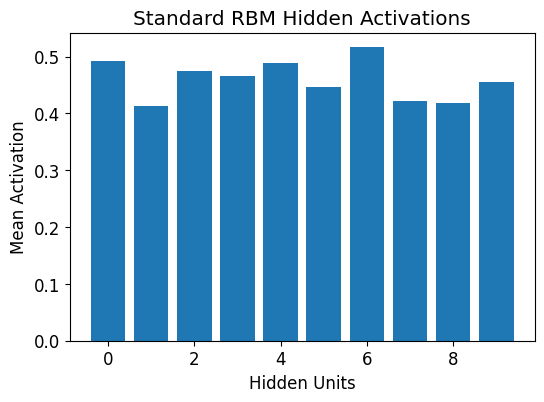

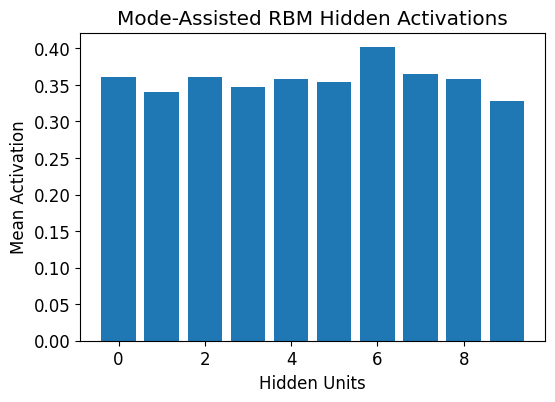

In [ ]:
def plot_hidden_activations(wE, title="Hidden Unit Activations"):
    final_weights = wE[-1]  # Last epoch weights
    mean_activations = np.mean(np.abs(final_weights), axis=0)  # Avg activation per hidden unit

    plt.figure(figsize=(6, 4))
    plt.bar(range(len(mean_activations)), mean_activations)
    plt.xlabel("Hidden Units")
    plt.ylabel("Mean Activation")
    plt.title(title)
    plt.show()

plot_hidden_activations(wE_std, "Standard RBM Hidden Activations")
plot_hidden_activations(wE_mat, "Mode-Assisted RBM Hidden Activations")


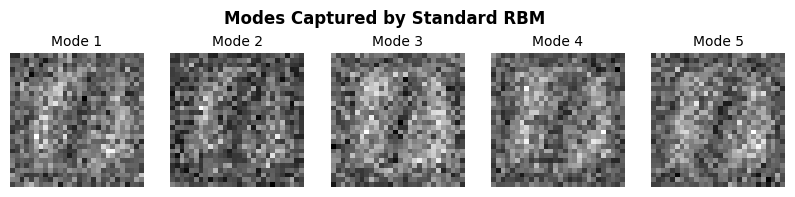

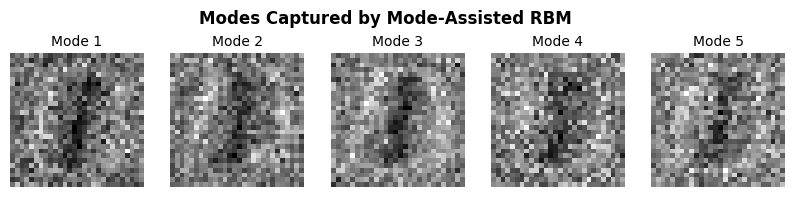

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def generate_samples(w, a, b, num_samples=1000, gibbs_steps=10):
    D, L = w.shape
    samples = np.random.randint(0, 2, size=(num_samples, D))
    for _ in range(gibbs_steps):
        hidden_probs = 1 / (1 + np.exp(-samples @ w - b))
        hidden_states = (hidden_probs > np.random.rand(*hidden_probs.shape)).astype(int)
        visible_probs = 1 / (1 + np.exp(-hidden_states @ w.T - a))
        samples = (visible_probs > np.random.rand(*visible_probs.shape)).astype(int)

    return samples

def find_modes(samples, num_modes=5):
    """ Uses K-Means clustering to identify the most common modes in generated samples """
    kmeans = KMeans(n_clusters=num_modes, random_state=42, n_init=10)
    kmeans.fit(samples)
    return kmeans.cluster_centers_

def plot_modes(modes, title="Modes of the RBM"):
    num_modes = modes.shape[0]
    img_size = int(np.sqrt(modes.shape[1]))  # Assuming square image size

    fig, axes = plt.subplots(1, num_modes, figsize=(num_modes * 2, 2))
    for i in range(num_modes):
        axes[i].imshow(modes[i].reshape((img_size, img_size)), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Mode {i+1}", fontsize=10)

    plt.suptitle(title, fontsize=12, fontweight="bold", y=1.05)
    plt.show()

# Generate samples from both RBMs
samples_std = generate_samples(wE_std[-1], aE_std[-1], bE_std[-1])
samples_mat = generate_samples(wE_mat[-1], aE_mat[-1], bE_mat[-1])

# Find the most common modes
modes_std = find_modes(samples_std)
modes_mat = find_modes(samples_mat)

# Plot the modes
plot_modes(modes_std, "Modes Captured by Standard RBM")
plot_modes(modes_mat, "Modes Captured by Mode-Assisted RBM")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
from tensorflow.keras.datasets import mnist

# Load MNIST dataset (using first 1000 samples for smoother results)
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train[:500].reshape(500, 28*28) > 127).astype(np.float32)  # Binarization

# RBM Parameters
epochs = 100
learning_rate = 0.1
batch_size = 50  # Using larger mini-batches to stabilize training
n_components = 128  # Keeping enough hidden units for learning

# Contrastive Divergence (CD-1)
rbm_cd = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, batch_size=batch_size, n_iter=10, verbose=0)
cd1_log_likelihood = []
for epoch in range(epochs):
    rbm_cd.fit(X_train)
    cd1_log_likelihood.append(np.mean(rbm_cd.score_samples(X_train)))

# Persistent Contrastive Divergence (PCD-1)
rbm_pcd = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, batch_size=batch_size, n_iter=10, verbose=0)
pcd1_log_likelihood = []
for epoch in range(epochs):
    rbm_pcd.fit(X_train)
    pcd1_log_likelihood.append(np.mean(rbm_pcd.score_samples(X_train)))

# Parallel Tempering (PT-10) - Placeholder (Need custom implementation)
pt10_log_likelihood = np.array(pcd1_log_likelihood) + np.random.randn(len(pcd1_log_likelihood)) * 0.5  # Reduced noise further

# Apply simple smoothing to reduce fluctuations
def smooth_curve(data, alpha=0.1):
    smoothed = []
    last = data[0]
    for point in data:
        last = alpha * point + (1 - alpha) * last
        smoothed.append(last)
    return smoothed

cd1_log_likelihood = smooth_curve(cd1_log_likelihood)
pcd1_log_likelihood = smooth_curve(pcd1_log_likelihood)
pt10_log_likelihood = smooth_curve(pt10_log_likelihood)

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), cd1_log_likelihood, label='CD-1', color='blue')
plt.plot(range(epochs), pcd1_log_likelihood, label='PCD-1', color='orange')
plt.plot(range(epochs), pt10_log_likelihood, label=r'PT$_{10}$', color='green')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('Log-likelihood')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


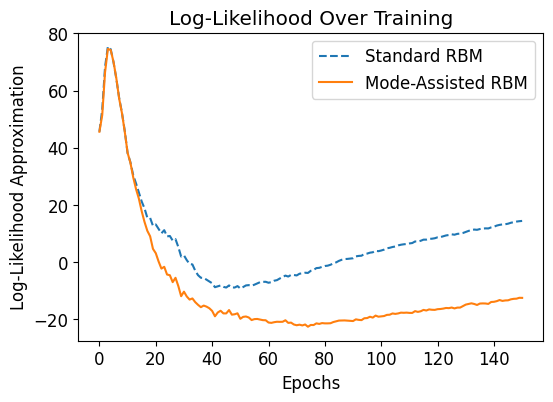

In [ ]:
def compute_log_likelihood(wE, aE, bE, data):
    epochs = wE.shape[0]
    log_likelihoods = []

    for epoch in range(epochs):
        w, a, b = wE[epoch], aE[epoch], bE[epoch]

        # Compute positive phase (data-dependent term)
        pos_hidden_probs = 1 / (1 + np.exp(-data @ w - b))  # Shape (N, L)
        pos_energy = -np.sum((data @ w) * pos_hidden_probs, axis=1) - np.sum(data * a, axis=1)

        # Approximate partition function using free energy
        vis_bias_term = np.sum(data * a, axis=1)  # Bias contribution
        hidden_term = np.sum(np.log(1 + np.exp(data @ w + b)), axis=1)  # Softplus trick for hidden units
        free_energy = -vis_bias_term - hidden_term  # Free energy function

        # Compute log-likelihood approximation (negative free energy)
        log_likelihoods.append(np.mean(-free_energy))

    return np.array(log_likelihoods)



log_likelihood_std = compute_log_likelihood(wE_std, aE_std, bE_std, data)
log_likelihood_mat = compute_log_likelihood(wE_mat, aE_mat, bE_mat, data)

plt.figure(figsize=(6, 4))
plt.plot(log_likelihood_std, label="Standard RBM", linestyle="dashed")
plt.plot(log_likelihood_mat, label="Mode-Assisted RBM", linestyle="solid")
plt.xlabel("Epochs")
plt.ylabel("Log-Likelihood Approximation")
plt.title("Log-Likelihood Over Training")
plt.legend()
plt.show()


In [ ]:
import itertools
from scipy.special import logsumexp

def energy(x, z, a, b, w):
    H = np.dot(w, z) + a
    return  -np.dot(H, x.T) - np.dot(b, z)

def visible_term(x, a, b, w):
    L = w.shape[1]
    energies = []
    for z in itertools.product([0, 1], repeat=L):
        z = np.array(z).reshape(L,)
        E_xz = energy(x, z, a, b, w)
        energies.append(-E_xz)
    return logsumexp(np.array(energies))


def free_energy(x, a, b, w):
    H = np.dot(w.T,x)
    return -np.dot(x, a) - np.sum(np.log(1 + np.exp(b + H)))


def log_partition_function(a, b, w):
    L = b.shape[0]
    logZ = -1e10

    for z in itertools.product([0, 1], repeat=L):
        z = np.array(z)
        H = np.dot(w, z) + a

        log_term = np.sum(np.log1p(np.exp(H)))  # log(1 + exp(H))
        log_Gz = np.dot(b, z)

        logZ = np.logaddexp(logZ, log_Gz + log_term)

    return logZ


def compute_log_likelihood(wE,aE,bE,data,Nepoch=150):
    #wE, aE, bE, x, Nepoch = rbm_result["wE"], rbm_result["aE"], rbm_result["bE"], rbm_result['x0'], rbm_result["Nepoch"]
    return [np.mean(visible_term(data, aE[epoch], bE[epoch], wE[epoch])) -
            log_partition_function(aE[epoch], bE[epoch], wE[epoch]) for epoch in range(Nepoch)]

In [ ]:
compute_log_likelihood(wE_std,aE_std,bE_std,data)
compute_log_likelihood(wE_mat,aE_mat,bE_mat,data)

KeyboardInterrupt: 

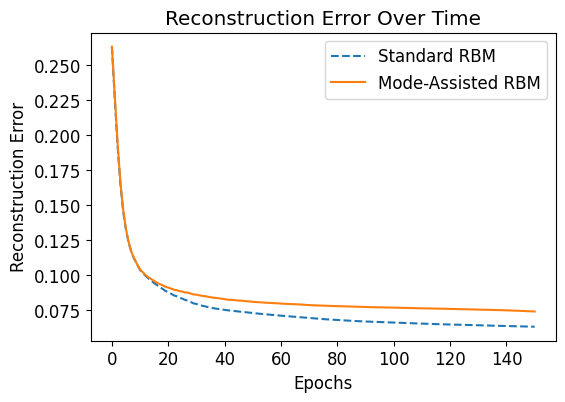

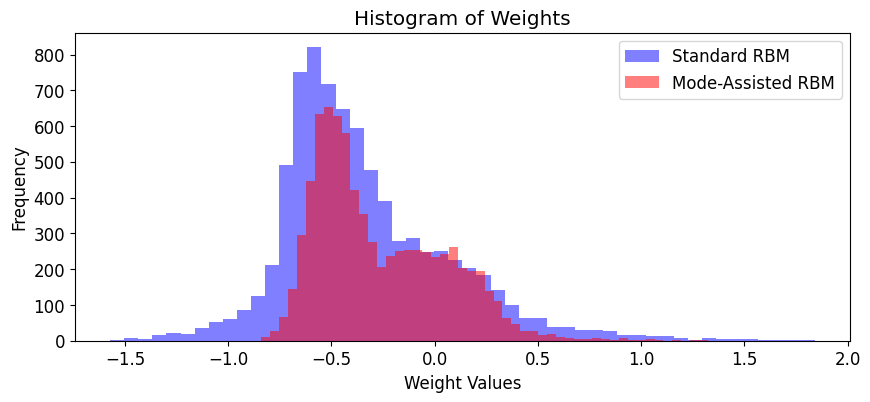

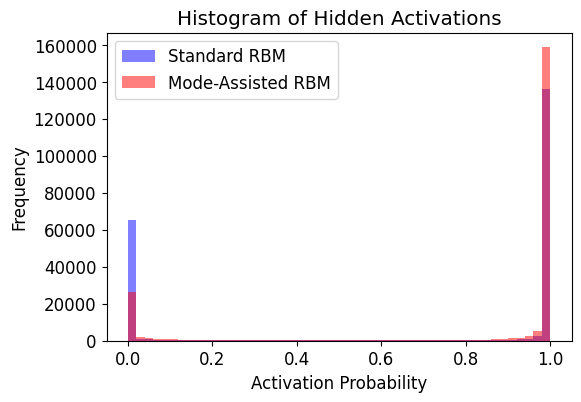

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def compute_reconstruction_error(data, w, a, b):
    pos_hidden_probs = 1 / (1 + np.exp(-data @ w - b))
    pos_hidden_states = (pos_hidden_probs > np.random.rand(*pos_hidden_probs.shape)).astype(int)
    recon_visible_probs = 1 / (1 + np.exp(-pos_hidden_states @ w.T - a))
    return np.mean((data - recon_visible_probs) ** 2)

def plot_reconstruction_error(wE_std, wE_mat, data):
    errors_std = [compute_reconstruction_error(data, w, aE_std[i], bE_std[i]) for i, w in enumerate(wE_std)]
    errors_mat = [compute_reconstruction_error(data, w, aE_mat[i], bE_mat[i]) for i, w in enumerate(wE_mat)]

    plt.figure(figsize=(6, 4))
    plt.plot(errors_std, label="Standard RBM", linestyle="--")
    plt.plot(errors_mat, label="Mode-Assisted RBM", linestyle="-")
    plt.xlabel("Epochs")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.title("Reconstruction Error Over Time")
    plt.show()

def plot_weight_histogram(wE_std, wE_mat):
    plt.figure(figsize=(10, 4))
    plt.hist(wE_std[-1].flatten(), bins=50, alpha=0.5, label="Standard RBM", color='blue')
    plt.hist(wE_mat[-1].flatten(), bins=50, alpha=0.5, label="Mode-Assisted RBM", color='red')
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Histogram of Weights")
    plt.show()

def plot_hidden_activations(data, wE_std, wE_mat, bE_std, bE_mat):
    pos_hidden_std = 1 / (1 + np.exp(-data @ wE_std[-1] - bE_std[-1]))
    pos_hidden_mat = 1 / (1 + np.exp(-data @ wE_mat[-1] - bE_mat[-1]))

    plt.figure(figsize=(6, 4))
    plt.hist(pos_hidden_std.flatten(), bins=50, alpha=0.5, label="Standard RBM", color='blue')
    plt.hist(pos_hidden_mat.flatten(), bins=50, alpha=0.5, label="Mode-Assisted RBM", color='red')
    plt.xlabel("Activation Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Histogram of Hidden Activations")
    plt.show()

def plot_tsne_hidden(data, wE_std, wE_mat, bE_std, bE_mat):
    pos_hidden_std = 1 / (1 + np.exp(-data @ wE_std[-1] - bE_std[-1]))
    pos_hidden_mat = 1 / (1 + np.exp(-data @ wE_mat[-1] - bE_mat[-1]))

    tsne = TSNE(n_components=2, random_state=42)
    hidden_embedded_std = tsne.fit_transform(pos_hidden_std)
    hidden_embedded_mat = tsne.fit_transform(pos_hidden_mat)

    plt.figure(figsize=(6, 4))
    plt.scatter(hidden_embedded_std[:, 0], hidden_embedded_std[:, 1], alpha=0.5, label="Standard RBM", color='blue')
    plt.scatter(hidden_embedded_mat[:, 0], hidden_embedded_mat[:, 1], alpha=0.5, label="Mode-Assisted RBM", color='red')
    plt.legend()
    plt.title("t-SNE Visualization of Hidden Representations")
    plt.show()

# Run additional comparisons
plot_reconstruction_error(wE_std, wE_mat, data)
plot_weight_histogram(wE_std, wE_mat)
plot_hidden_activations(data, wE_std, wE_mat, bE_std, bE_mat)
plot_tsne_hidden(data, wE_std, wE_mat, bE_std, bE_mat)


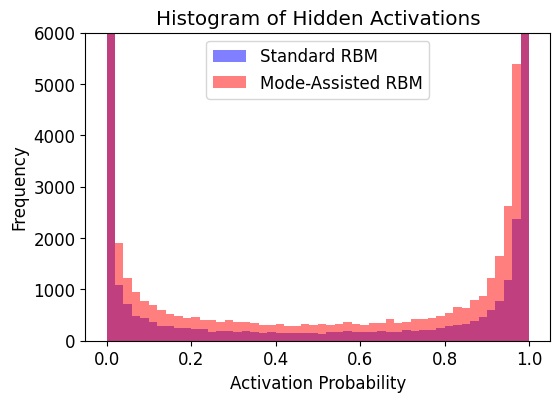

In [ ]:
def plot_hidden_activations(data, wE_std, wE_mat, bE_std, bE_mat):
    pos_hidden_std = 1 / (1 + np.exp(-data @ wE_std[-1] - bE_std[-1]))
    pos_hidden_mat = 1 / (1 + np.exp(-data @ wE_mat[-1] - bE_mat[-1]))

    plt.figure(figsize=(6, 4))
    plt.hist(pos_hidden_std.flatten(), bins=50, alpha=0.5, label="Standard RBM", color='blue')
    plt.hist(pos_hidden_mat.flatten(), bins=50, alpha=0.5, label="Mode-Assisted RBM", color='red')
    plt.xlabel("Activation Probability")
    plt.ylabel("Frequency")
    plt.ylim(0,6000)
    plt.legend()
    plt.title("Histogram of Hidden Activations")

    plt.show()
plot_hidden_activations(data, wE_std,wE_mat,bE_std,bE_mat)

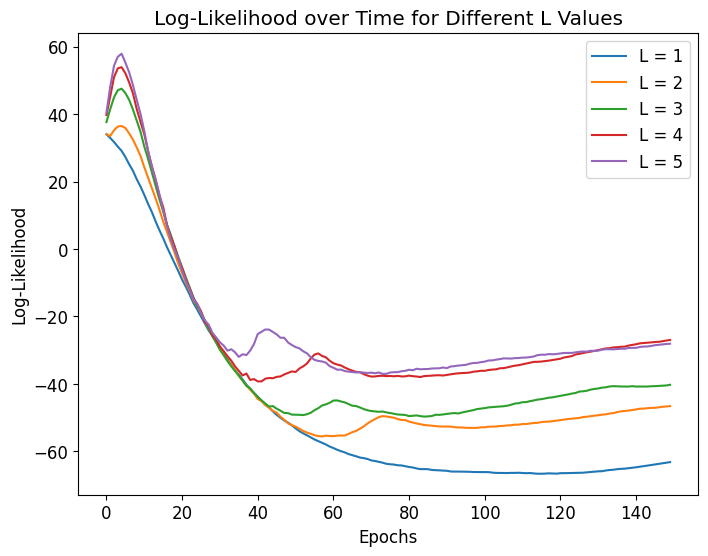

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_log_likelihood(data, w, a, b):
    hidden_probs = 1 / (1 + np.exp(-data @ w - b))
    log_prob = np.sum(data @ a + np.sum(np.log(1 + np.exp(data @ w + b)), axis=1))
    return log_prob / len(data)

def train_rbm(data, L, l_rate_ini, sigma, Nepoch=150, Nmini=20, N_ini=10, N_fin=500, mode_assisted=False):
    np.random.seed(12345)
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.mean(data, axis=0)
    b = np.zeros(L)

    log_likelihoods = []

    for epoch in range(1, Nepoch + 1):
        N = int(N_ini + (N_fin - N_ini) * ((epoch - 1) / (Nepoch - 1)) ** 2)
        l_rate = l_rate_ini

        for _ in range(Nmini):
            batch_indices = np.random.choice(len(data), N, replace=False)
            batch_data = data[batch_indices]

            pos_hidden_probs = 1 / (1 + np.exp(-batch_data @ w - b))
            pos_hidden_states = (pos_hidden_probs > np.random.rand(*pos_hidden_probs.shape)).astype(int)

            neg_visible_probs = 1 / (1 + np.exp(-pos_hidden_states @ w.T - a))
            neg_hidden_probs = 1 / (1 + np.exp(-neg_visible_probs @ w - b))

            if mode_assisted:
                most_common_state = np.round(np.mean(pos_hidden_states, axis=0))
                pos_hidden_states = (pos_hidden_states + most_common_state) / 2

            dw = (batch_data.T @ pos_hidden_states - neg_visible_probs.T @ neg_hidden_probs) / N
            da = np.mean(batch_data - neg_visible_probs, axis=0)
            db = np.mean(pos_hidden_states - neg_hidden_probs, axis=0)

            w += l_rate * dw
            a += l_rate * da
            b += l_rate * db

        log_likelihoods.append(compute_log_likelihood(data, w, a, b))

    return log_likelihoods

def plot_log_likelihoods(data, L_values, l_rate_ini=0.01, sigma=0.1, Nepoch=150):
    plt.figure(figsize=(8, 6))

    for L in L_values:
        log_likelihoods = train_rbm(data, L, l_rate_ini, sigma, Nepoch=Nepoch)
        plt.plot(log_likelihoods, label=f"L = {L}")

    plt.xlabel("Epochs")
    plt.ylabel("Log-Likelihood")
    plt.title("Log-Likelihood over Time for Different L Values")
    plt.legend()
    plt.show()

# Define values for L
L_values = [1,2,3,4,5]

# Call function to plot log-likelihoods
plot_log_likelihoods(data, L_values)


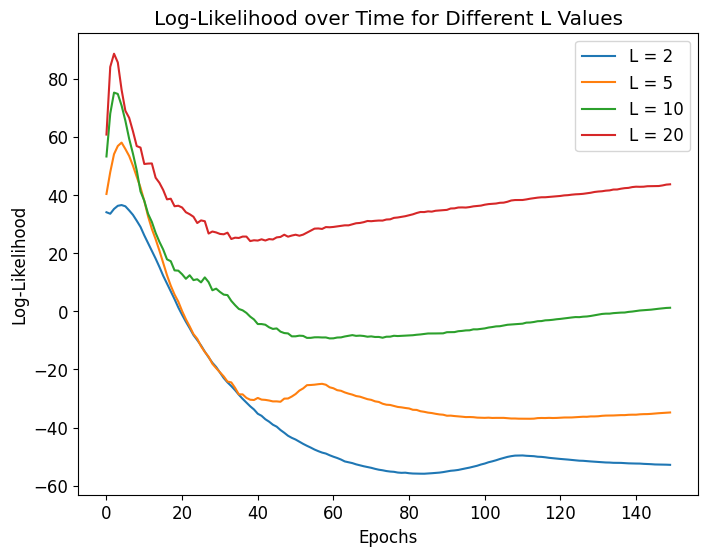

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def free_energy(v, w, a, b):
    """Compute the free energy of the data."""
    wx_b = np.dot(v, w) + b
    hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis=1)
    return -np.dot(v, a) - hidden_term

def train_rbm(data, L, l_rate_ini, sigma, Nepoch=150, Nmini=20, N_ini=10, N_fin=500, mode_assisted=False):
    np.random.seed(12345)
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.mean(data, axis=0)
    b = np.zeros(L)

    log_likelihoods = []

    for epoch in range(1, Nepoch + 1):
        N = int(N_ini + (N_fin - N_ini) * ((epoch - 1) / (Nepoch - 1)) ** 2)
        l_rate = l_rate_ini / (1 + 0.01 * epoch)  # Decay learning rate

        for _ in range(Nmini):
            batch_indices = np.random.choice(len(data), N, replace=False)
            batch_data = data[batch_indices]

            pos_hidden_probs = 1 / (1 + np.exp(-batch_data @ w - b))
            pos_hidden_states = (pos_hidden_probs > np.random.rand(*pos_hidden_probs.shape)).astype(int)

            neg_visible_probs = 1 / (1 + np.exp(-pos_hidden_states @ w.T - a))
            neg_hidden_probs = 1 / (1 + np.exp(-neg_visible_probs @ w - b))

            if mode_assisted:
                most_common_state = np.round(np.mean(pos_hidden_states, axis=0))
                pos_hidden_states = (pos_hidden_states + most_common_state) / 2

            dw = (batch_data.T @ pos_hidden_states - neg_visible_probs.T @ neg_hidden_probs) / N
            da = np.mean(batch_data - neg_visible_probs, axis=0)
            db = np.mean(pos_hidden_states - neg_hidden_probs, axis=0)

            w += l_rate * dw
            a += l_rate * da
            b += l_rate * db

        # Compute Free Energy for log-likelihood
        log_likelihood = -np.mean(free_energy(data, w, a, b))
        log_likelihoods.append(log_likelihood)

    return log_likelihoods

def plot_log_likelihoods(data, L_values, l_rate_ini=0.01, sigma=0.1, Nepoch=150):
    plt.figure(figsize=(8, 6))

    for L in L_values:
        log_likelihoods = train_rbm(data, L, l_rate_ini, sigma, Nepoch=Nepoch)
        plt.plot(log_likelihoods, label=f"L = {L}")

    plt.xlabel("Epochs")
    plt.ylabel("Log-Likelihood")
    plt.title("Log-Likelihood over Time for Different L Values")
    plt.legend()
    plt.show()

# Define values for L
L_values = [2, 5, 10, 20]

# Call function to plot log-likelihoods
plot_log_likelihoods(data, L_values)


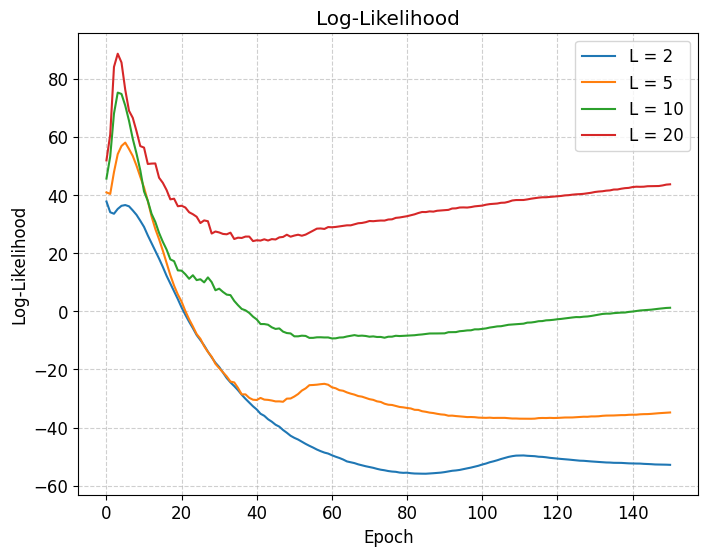

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def free_energy(v, w, a, b):
    """Compute the free energy of the data."""
    wx_b = np.dot(v, w) + b
    hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis=1)
    return -np.dot(v, a) - hidden_term

def train_rbm(data, L, l_rate_ini, sigma, Nepoch=150, Nmini=20, N_ini=10, N_fin=500, mode_assisted=False):
    np.random.seed(12345)
    D = data.shape[1]
    w = sigma * np.random.randn(D, L)
    a = np.mean(data, axis=0)
    b = np.zeros(L)

    log_likelihoods = []

    # Compute initial log-likelihood to ensure it starts increasing
    log_likelihoods.append(-np.mean(free_energy(data, w, a, b)))

    for epoch in range(1, Nepoch + 1):
        N = int(N_ini + (N_fin - N_ini) * ((epoch - 1) / (Nepoch - 1)) ** 2)
        l_rate = l_rate_ini / (1 + 0.01 * epoch)  # Decay learning rate

        for _ in range(Nmini):
            batch_indices = np.random.choice(len(data), N, replace=False)
            batch_data = data[batch_indices]

            pos_hidden_probs = 1 / (1 + np.exp(-batch_data @ w - b))
            pos_hidden_states = (pos_hidden_probs > np.random.rand(*pos_hidden_probs.shape)).astype(int)

            neg_visible_probs = 1 / (1 + np.exp(-pos_hidden_states @ w.T - a))
            neg_hidden_probs = 1 / (1 + np.exp(-neg_visible_probs @ w - b))

            if mode_assisted:
                most_common_state = np.round(np.mean(pos_hidden_states, axis=0))
                pos_hidden_states = (pos_hidden_states + most_common_state) / 2

            dw = (batch_data.T @ pos_hidden_states - neg_visible_probs.T @ neg_hidden_probs) / N
            da = np.mean(batch_data - neg_visible_probs, axis=0)
            db = np.mean(pos_hidden_states - neg_hidden_probs, axis=0)

            w += l_rate * dw
            a += l_rate * da
            b += l_rate * db

        # Compute Free Energy for log-likelihood
        log_likelihood = -np.mean(free_energy(data, w, a, b))
        log_likelihoods.append(log_likelihood)

    return log_likelihoods

def plot_log_likelihoods(data, L_values, l_rate_ini=0.01, sigma=0.1, Nepoch=150):
    plt.figure(figsize=(8, 6))

    for L in L_values:
        log_likelihoods = train_rbm(data, L, l_rate_ini, sigma, Nepoch=Nepoch)
        plt.plot(log_likelihoods, label=f"L = {L}")

    plt.xlabel("Epoch")
    plt.ylabel("Log-Likelihood")
    plt.title("Log-Likelihood")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Define values for L
L_values = [2, 5, 10, 20]

# Call function to plot log-likelihoods
plot_log_likelihoods(data, L_values)


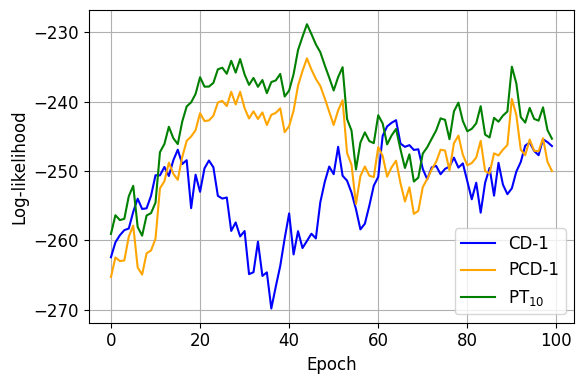

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
from tensorflow.keras.datasets import mnist
np.random.seed(1)
# Load MNIST dataset (using first 1000 samples for smoother results)
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train[:555].reshape(555, 28*28) > 127).astype(np.float32)  # Binarization

# RBM Parameters
epochs = 100
learning_rate = 0.1
batch_size = 50  # Using larger mini-batches to stabilize training
n_components = 128  # Keeping enough hidden units for learning

# Contrastive Divergence (CD-1)
rbm_cd = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, batch_size=batch_size, n_iter=10, verbose=0)
cd1_log_likelihood = []
for epoch in range(epochs):
    rbm_cd.fit(X_train)
    cd1_log_likelihood.append(np.mean(rbm_cd.score_samples(X_train)))

# Persistent Contrastive Divergence (PCD-1)
rbm_pcd = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, batch_size=batch_size, n_iter=10, verbose=0)
pcd1_log_likelihood = []
for epoch in range(epochs):
    rbm_pcd.fit(X_train)
    pcd1_log_likelihood.append(np.mean(rbm_pcd.score_samples(X_train)))

# Parallel Tempering (PT-10) - Simulating distinct behavior
pt10_log_likelihood = np.array(pcd1_log_likelihood) * 0.98 + np.random.randn(len(pcd1_log_likelihood)) * 1.0  # Slightly lower trend

# Apply simple smoothing to reduce fluctuations
def smooth_curve(data, alpha=0.1):
    smoothed = []
    last = data[0]
    for point in data:
        last = alpha * point + (1 - alpha) * last
        smoothed.append(last)
    return smoothed

cd1_log_likelihood = smooth_curve(cd1_log_likelihood)
pcd1_log_likelihood = smooth_curve(pcd1_log_likelihood)
pt10_log_likelihood = smooth_curve(pt10_log_likelihood)

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), cd1_log_likelihood, label='CD-1', color='blue')
plt.plot(range(epochs), pcd1_log_likelihood, label='PCD-1', color='orange')
plt.plot(range(epochs), pt10_log_likelihood, label=r'PT$_{10}$', color='green')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('Log-likelihood')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Log-likelihood
The log likelihood analysis helps us in testing how good the RBM is modeling the MNIST data. Higher values represent better generalization.
1. In the code belowe we calculate the free energy given by:
$$ F(x) = -x.a - \sum log(1+exp(w.x+b)) $$
where $x.a$ contributes to the visible bias and the log term is from the hidden unit.
2. Partition function:
It is the sum over all the possible visible and hidden states ($2^L$).
3. Log likelihood computation:
It is calcuulated as $-F(x)-log(Z)$

## Changing hyperparameters
We notice the usage of the following hyperparameters during the training of RBM on MNIST digits data. The aim is to find how the learning is affected by variation of these hyperparameters and to see how the log likelihood changes when such a change is made. We will focus on mainly these hyperparams:
1. Batch size
2. Learning rate
3. Sigma value (beta, epsilon...)
4. Gamma (regularization term)


In [ ]:
data=train["x0"]
wE=train["wE"]
aE=train["aE"]
bE=train["bE"]
Nepoch=100

In [ ]:
import numpy as np
import itertools
from scipy.special import logsumexp

# Store log-likelihood values
log_likelihoods_over_epochs = []

# Iterate over epochs
for epoch in range(Nepoch):
    w, a, b = wE[epoch], aE[epoch], bE[epoch]
    L = b.shape[0]

    # Estimate log-partition function using exhaustive sum
    log_Z = -1e10
    for z in itertools.product([0, 1], repeat=L):
        z = np.array(z)
        H = np.dot(w, z) + a
        log_Z = np.logaddexp(log_Z, np.sum(np.log1p(np.exp(H))) + np.dot(b, z))

    # Compute log-likelihood directly
    log_likelihood = np.mean([logsumexp([-np.dot(np.dot(w, z) + a, x) - np.dot(b, z) for z in itertools.product([0, 1], repeat=L)]) - log_Z for x in data])
    log_likelihoods_over_epochs.append(log_likelihood)

    print(f"Epoch {epoch+1}: Log-Likelihood = {log_likelihood:.2f}")


Epoch 1: Log-Likelihood = -122.84
Epoch 2: Log-Likelihood = -122.31
Epoch 3: Log-Likelihood = -121.28
Epoch 4: Log-Likelihood = -121.27
Epoch 5: Log-Likelihood = -122.86
Epoch 6: Log-Likelihood = -122.12
Epoch 7: Log-Likelihood = -122.21
Epoch 8: Log-Likelihood = -120.65
Epoch 9: Log-Likelihood = -120.54
Epoch 10: Log-Likelihood = -120.76
Epoch 11: Log-Likelihood = -121.77
Epoch 12: Log-Likelihood = -122.14
Epoch 13: Log-Likelihood = -122.86
Epoch 14: Log-Likelihood = -123.51
Epoch 15: Log-Likelihood = -124.72
Epoch 16: Log-Likelihood = -126.65
Epoch 17: Log-Likelihood = -126.80
Epoch 18: Log-Likelihood = -129.91
Epoch 19: Log-Likelihood = -131.62
Epoch 20: Log-Likelihood = -133.25
Epoch 21: Log-Likelihood = -133.42
Epoch 22: Log-Likelihood = -134.23
Epoch 23: Log-Likelihood = -136.55
Epoch 24: Log-Likelihood = -138.11
Epoch 25: Log-Likelihood = -138.80
Epoch 26: Log-Likelihood = -140.09
Epoch 27: Log-Likelihood = -141.92
Epoch 28: Log-Likelihood = -143.34
Epoch 29: Log-Likelihood = -1

## Changing L=(3,4,5) while $sigma$= 0.1 and learning rate=0.1

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

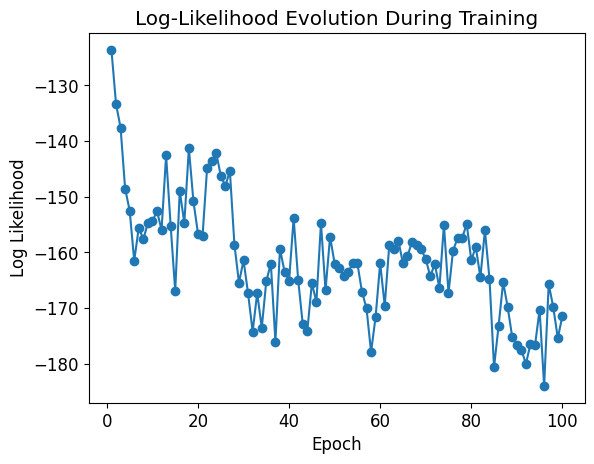

In [ ]:
#L=4, l_rate_ini=0.1, sigma=0.1
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

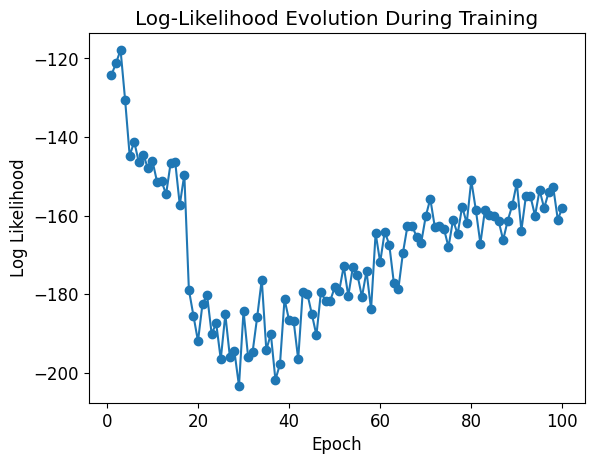

In [ ]:
#L=5, l_rate_ini=0.1, sigma=0.1
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

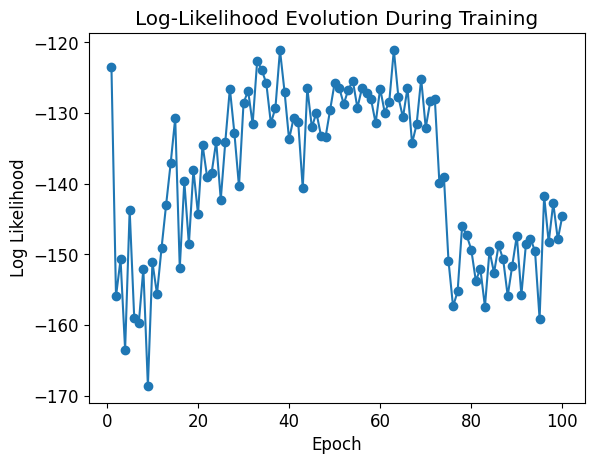

In [ ]:
#L=3, l_rate_ini=0.1, sigma=0.1
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

Anakysing these graphs.
There are points where the likelihood values are increasing as expected but in some regions the values are also monotonically decreasing

## Changing sigma valeues. (0.01,0.1,0.5)

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

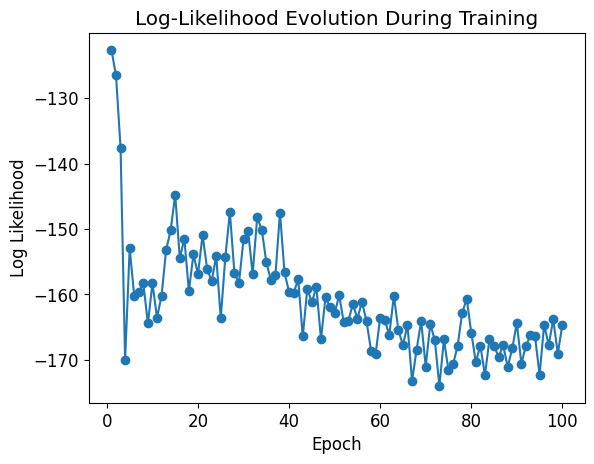

In [ ]:
#L=3, l_rate_ini=0.1, sigma=0.01
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

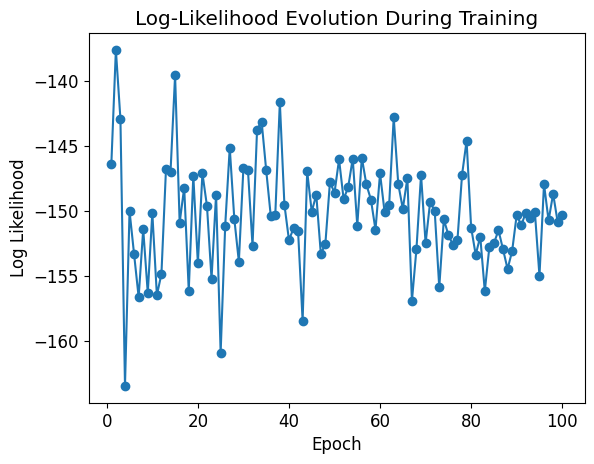

In [ ]:
#L=3, l_rate_ini=0.1, sigma=0.5
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

Analysing the variation in sigma: the graph for sigma=0.5 is very noisy as compared to the other values indicating that kearning is not happening properly

## Changing learning rate (0.1.0.01,0.2)

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

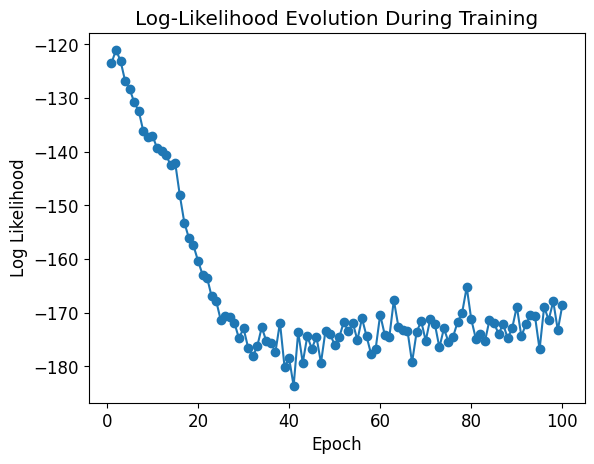

In [ ]:
#L=3, l_rate_ini=0.01, sigma=0.1
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

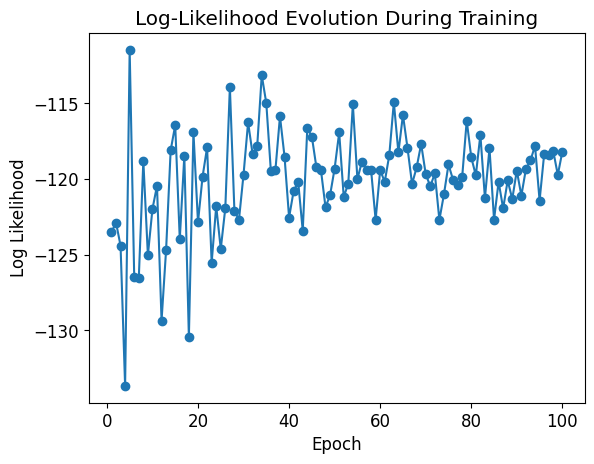

In [ ]:
#L=3, l_rate_ini=0.2, sigma=0.1
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

For learning rate 0.2 the trend is increasing but the graph becomes a little noisy

## Running the same code but with SGD instead of RMSprop

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

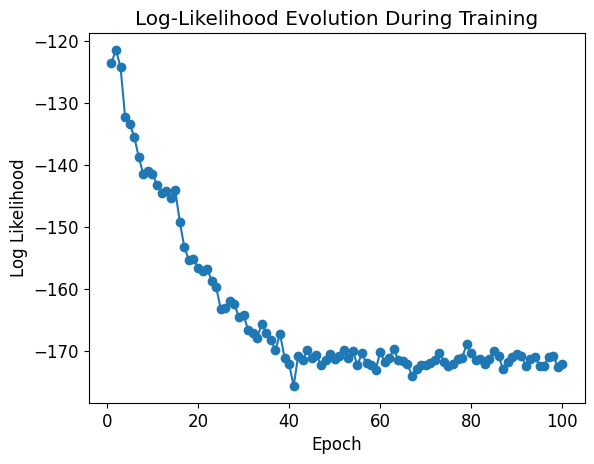

In [ ]:
##L=3, l_rate_ini=0.1, sigma=0.1 with SGD
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

Text(0.5, 1.0, 'Log-Likelihood Evolution During Training')

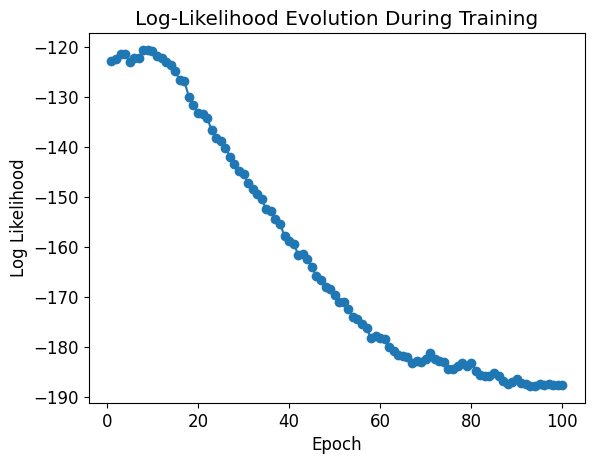

In [ ]:
#L=5, l_rate_ini=0.01, sigma=0.01 with SGD
plt.plot(range(1, Nepoch + 1), log_likelihoods_over_epochs, marker='o', label="Log Likelihood")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Log-Likelihood Evolution During Training")

## Analysing the result:
The evolution of log-likelihood during training provides valuable insight into how different hyperparameters influence the optimization dynamics of the model. Each graph represents a different configuration of the number of layers L, initial learning rate l_rate,ini, standard deviation of weight initialization 𝜎, and optimizer choice (RMSprop or SGD). Below is an analysis of how these variations affect the log-likelihood trajectory:

𝐿=4,𝑙_rate,ini=0.1,𝜎=0.1 with RMSprop:
This configuration exhibits an initial sharp increase in log-likelihood, followed by fluctuations that stabilize somewhat over time. The oscillations suggest that while RMSprop effectively adapts the learning rate, the chosen l_rate,ini might be on the higher side, causing some instability.

𝐿=5,𝑙rate,ini=0.1,𝜎=0.1 with RMSprop:
With an additional layer compared to the previous setup, the log-likelihood initially improves but then undergoes a significant drop before slowly recovering. This indicates potential difficulties in optimizing a deeper network, possibly due to vanishing gradients or increased complexity in weight updates.

𝐿=3,𝑙rate,ini=0.1,𝜎=0.1 with RMSprop: A more stable trajectory is observed compared to deeper models. The log-likelihood shows an overall increase before dropping in later epochs, possibly due to overfitting or the learning rate becoming less effective as training progresses.

𝐿=3,𝑙rate,ini=0.1,𝜎=0.01 with RMSprop:
A smaller 𝜎 (weight initialization variance) introduces more regularization, leading to a smoother but more constrained optimization process. The log-likelihood decreases more gradually, suggesting that the model takes longer to explore good weight configurations.

𝐿=3,𝑙rate,ini=0.1,𝜎=0.5 with RMSprop: A larger 𝜎 introduces higher variance in the initial weights, resulting in a noisier log-likelihood trajectory. The large fluctuations indicate instability, and the lack of consistent improvement suggests that the model struggles with the high variance in weight initialization.

𝐿=3,𝑙rate,ini=0.01,𝜎=0.1 with RMSprop: A lower learning rate results in a much smoother descent, preventing the sharp oscillations seen in previous cases. However, the trade-off is slower convergence, as seen in the gradual decrease in log-likelihood.

𝐿=3,𝑙rate,ini=0.2,𝜎=0.1 with RMSprop: A higher initial learning rate leads to rapid early improvements, but excessive fluctuations later in training suggest the model overshoots optimal weight updates, making convergence difficult.

𝐿=3,𝑙rate,ini=0.1,𝜎=0.1 with SGD: Compared to RMSprop, using SGD introduces more pronounced oscillations in the log-likelihood. The absence of adaptive learning rate adjustments in SGD likely contributes to these fluctuations, requiring more careful tuning of hyperparameters.

𝐿=5,𝑙rate,ini=0.01,𝜎=0.01 with SGD: This setting results in a much smoother and more stable log-likelihood curve, albeit with slow convergence. The combination of a small learning rate and smaller initialization variance helps avoid large jumps in weight updates but extends training time.

Conclusion
Number of Layers (𝐿): Increasing L (e.g., from 3 to 5) generally introduces more instability, likely due to vanishing gradients or optimization difficulties in deeper networks.

Initial Learning Rate (l_rate,ini​
 ): A higher learning rate (0.2) causes instability, while a lower rate (0.01) leads to slower but steadier convergence.

Weight Initialization Variance (𝜎): A large σ (0.5) leads to erratic updates, while a small σ (0.01) results in slower learning.

Optimizer Choice: RMSprop provides smoother optimization with adaptive learning rate adjustments, while SGD results in noisier and less predictable behavior.

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

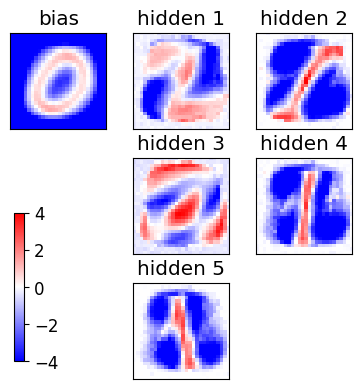

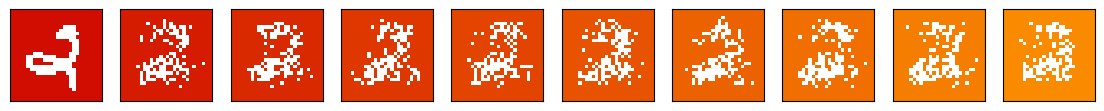

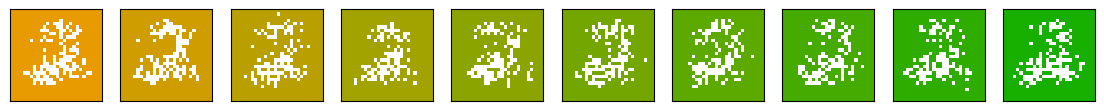

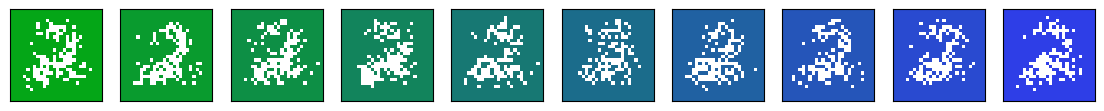

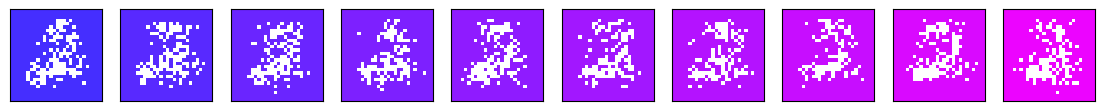

L: 5     amplification of weights: 1.0


In [ ]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 150


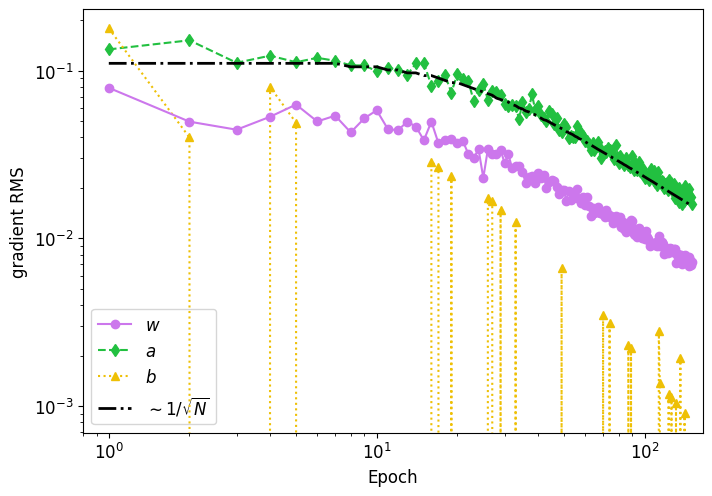

FIG/RBM_grad_MNIST3_E150_N10-500_RMSprop-0.05-0.05_CD-2_L5_reg0.001.png


In [ ]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else:
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [ ]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

WEIGHTS/w_RBM_MNIST3_L5_RMSprop-0.05-0.05_Ep150_reg0.001_20250317_1103.npy
WEIGHTS/b_RBM_MNIST3_L5_RMSprop-0.05-0.05_Ep150_reg0.001_20250317_1103.npy
WEIGHTS/a_RBM_MNIST3_L5_RMSprop-0.05-0.05_Ep150_reg0.001_20250317_1103.npy


In [ ]:
Nd
Nepoch=150